# <span style = 'color: red'>***B.*** **Modelación**.

- **Sara Palacios Duque**
- **Manuela Granda Muñoz**
- **Sebastián Restrepo Betancur**
- **Simón Cuartas Rendón**

En este notebook se llevará a cabo la etapa de modelamiento, en la cual se ajustarán distintos modelos de aprendizaje de máquina de clasificación para poder predecir si una determinada transacción se puede etiquetar como fraudulenta. Para ello es importante tener en cuenta que:

- Se usará la base de datos con preprocesamiento que se obtuvo a través del *notebook* `A_preprocesamiento.ipynb`. Fundamentalmente, a esta base se le realizó un PCA para reducirle la dimensionalidad asegurando que se abarcase al menos un $95 \%$ de la variabilidad del conjunto de datos inicial, además de haber pasado por un proceso de estandarización y de equilibrio, pues la base inicial es profundamente desbalanceada.
- En los distintos modelos se hará un proceso de **ajuste de hiperparámetros** vía **validación cruzada**. En todo caso, se tiene una porción de datos que no usarán para el entrenamiento de los modelos, esto con el propósito de poder validar estos con información que nunca han visto.
    - Bajo este proceso, se va a tratar de minimizar la métrica $F1$ en aras de optimizar tanto la precisión como la exhaustividad del modelo.
- Se dejará una subdivisión para aquellos casos en los que no sea aplicable el proceso de validación cruzada, dejando el 30 % del conjunto de validación para una segunda validación el 70 % para *test*.
- Para los modelos se hará también un proceso de selección de características automático. Esto se integrará en los diferentes *pipelines*.

Se iniciará con la apertura de diferentes paquetes importantes que se usarán a lo largo del *notebook*.

In [48]:
#
# Apertura de paquetes

# Paquetes básicos
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display

# Paquetes para ajuste de modelos
import statsmodels.api as sm
from statsmodels.formula.api import ols
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.metrics import (
    confusion_matrix,
    ConfusionMatrixDisplay,
    cohen_kappa_score,
    classification_report,
    accuracy_score,
    f1_score,
    precision_score,
    recall_score,
    roc_auc_score,
    roc_curve,
)
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import SelectKBest, f_classif, mutual_info_classif

# Modelos propiamente
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.neural_network import MLPClassifier
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier

#
# Configuración de salidas de pandas
pd.set_option('display.notebook_repr_html', False)

# <span style = 'color: red'>***1.***</span> Lectura de los datos

Se inicia con la lectura de los datos de entrenamiento y validación obtenidos previamente:

In [2]:
#
# Lectura de los datos
df_train = pd.read_csv('../Datos/Preprocesados/train.csv.zip', compression='zip', )
df_val = pd.read_csv('../Datos/Preprocesados/validation.csv.zip', compression='zip', )

# Dimensionalidad
print(
    f'El conjunto de entrenamiento tiene {df_train.shape[0]} filas y {df_train.shape[1]} columnas.',
    f'El conjunto de validación tiene {df_val.shape[0]} filas y {df_val.shape[1]} columnas.',
    sep='\n'
)

El conjunto de entrenamiento tiene 453204 filas y 18 columnas.
El conjunto de validación tiene 56746 filas y 18 columnas.


/var/folders/sk/70417qyj4msbzpr87cqckzgm0000gn/T/ipykernel_7539/380392988.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=data, x=column, palette='viridis')


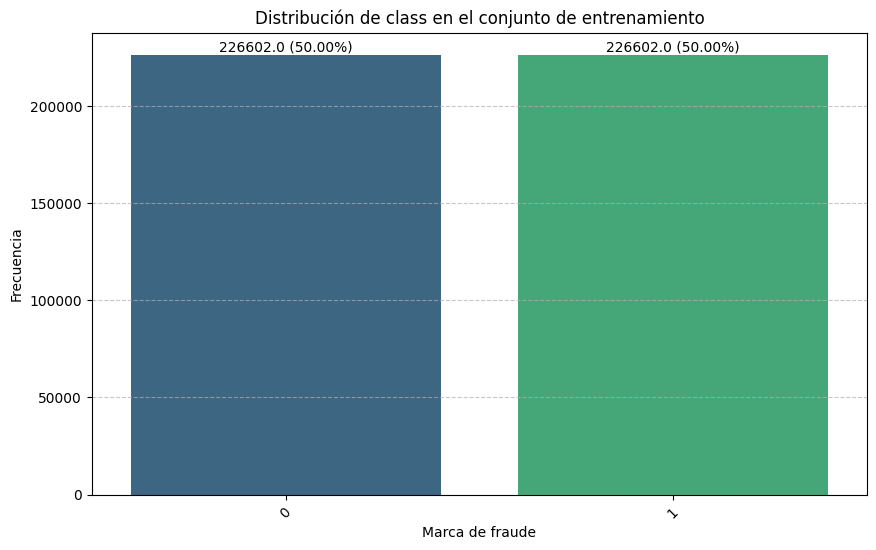

In [15]:
#
# Función que grafica la distribución
def plot_distribution(data, column, conjunto):
    plt.figure(figsize=(10, 6))
    sns.countplot(data=data, x=column, palette='viridis')
    # Agregar proporción y cantidad absoluta encima de cada barra
    total = len(data)
    for p in plt.gca().patches:
        height = p.get_height()
        plt.text(p.get_x() + p.get_width() / 2., height, f'{height} ({height / total:.2%})',
                 ha='center', va='bottom', fontsize=10, color='black')
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.title(f'Distribución de {column} en el conjunto de {conjunto}')
    plt.xlabel('Marca de fraude')
    plt.ylabel('Frecuencia')
    plt.xticks(rotation=45)
    plt.show()

plot_distribution(df_train, 'class', 'entrenamiento')

/var/folders/sk/70417qyj4msbzpr87cqckzgm0000gn/T/ipykernel_7539/380392988.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=data, x=column, palette='viridis')


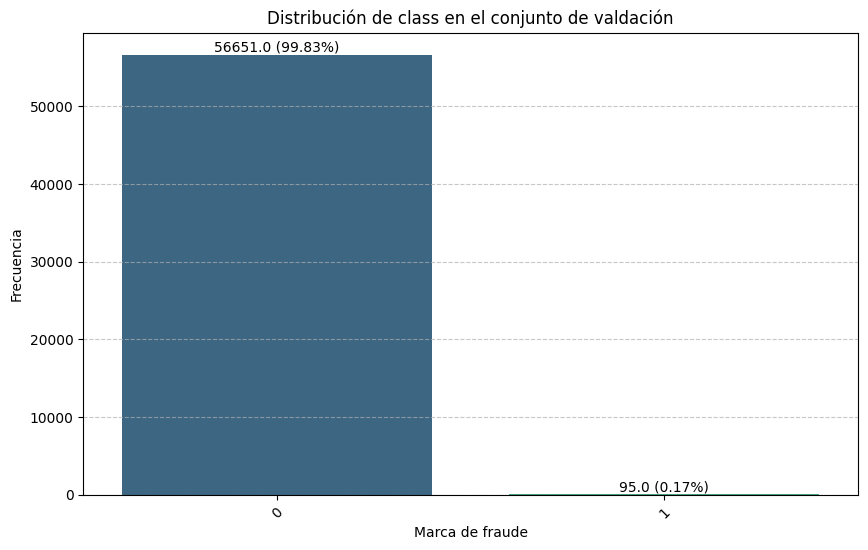

In [16]:
plot_distribution(df_val, 'class', 'valdación')

Efectivamente, se está trabajando con los datos preprocesados, ya que tiene menos dimensiones que los datos iniciales y las clases de la variable objetivo, `class`, están equilibradas en el caso del conjunto de entrenamiento. Este no es el caso del conjunto de validación, ya que se pretende conservar la distribución real de los datos en un conjunto que no ha sido jamás estudiado por los diferentes modelos.

Antes de pasar a la modelación propiamente, se aborda el proceso de obtención de bases de test y de validación a partir de los datos de entrenamiento, tal y como se mencionó previamente.

In [4]:
df_test_alfa, df_val_alfa = train_test_split(df_val, test_size=0.3, stratify=df_val['class'], random_state=202508)
print(
    f'El conjunto de test tiene {df_test_alfa.shape[0]} filas y {df_test_alfa.shape[1]} columnas.',
    f'El conjunto de validación tiene {df_val_alfa.shape[0]} filas y {df_val_alfa.shape[1]} columnas.',
    sep='\n'
)

El conjunto de test tiene 39722 filas y 18 columnas.
El conjunto de validación tiene 17024 filas y 18 columnas.


Y se crea la matriz de diseño que contiene todas las variables explicativas, así como el vector de respuestas: 

In [5]:
X_train = df_train.drop('class', axis=1)
y_train = df_train['class']
X_test = df_val.drop('class', axis=1)
y_test = df_val['class']

Además, se define la siguiente función que permite obtener los resultados de los modelos tanto para el conjunto de entrenamiento como para el de validación.

In [11]:
def plot_confusion_and_roc(model, X_train=X_train, y_train=y_train, X_test=X_test, y_test=y_test, modelo=None, class_labels=None):
    # Predicciones
    y_pred_train = model.predict(X_train)
    y_proba_train = model.predict_proba(X_train)[:, 1]
    y_pred = model.predict(X_test)
    y_proba = model.predict_proba(X_test)[:, 1]

    # Matriz de confusión
    cm_train = confusion_matrix(y_train, y_pred_train, labels=class_labels)
    cm_test = confusion_matrix(y_test, y_pred, labels=class_labels)

    # Curva ROC 
    fpr_train, tpr_train, _ = roc_curve(y_train, y_proba_train)
    fpr_test, tpr_test, _ = roc_curve(y_test, y_proba)
    auc_train = roc_auc_score(y_train, y_proba_train)
    auc_test = roc_auc_score(y_test, y_proba)

    acc_test = accuracy_score(y_test, y_pred)
    kappa_test = cohen_kappa_score(y_test, y_pred)

    acc_train = accuracy_score(y_train, y_pred_train)
    kappa_train = cohen_kappa_score(y_train, y_pred_train)

    # Figura con subplots 
    fig, axes = plt.subplots(2, 2, figsize=(6, 5))

    # Matriz de confusión como porcentaje (Entrenamiento)
    cm_train_pct = cm_train / cm_train.sum() * 100
    sns.heatmap(cm_train_pct, annot=True, fmt='.1f', cmap='Blues', ax=axes[0, 0])
    axes[0, 0].set_title('Matriz de confusión (%): entrenamiento', fontsize=10)
    axes[0, 0].set_xlabel('Predicción')
    axes[0, 0].set_ylabel('Real')

    # Matriz de confusión como porcentaje (Validación)
    cm_test_pct = cm_test / cm_test.sum() * 100
    sns.heatmap(cm_test_pct, annot=True, fmt='.1f', cmap='Blues', ax=axes[0, 1])
    axes[0, 1].set_title('Matriz de confusión (%): validación', fontsize=10)
    axes[0, 1].set_xlabel('Predicción')
    axes[0, 1].set_ylabel('Real')

    # Curva ROC - entrenamiento
    axes[1, 0].plot(fpr_train, tpr_train, color='darkorange',
                    label=f'AUC = {auc_train:.2f}\nExact: {acc_train:.2f}\nKappa = {kappa_train:.2f}')
    axes[1, 0].plot([0, 1], [0, 1], color='navy', linestyle='--')
    axes[1, 0].set_xlim([0.0, 1.0])
    axes[1, 0].set_ylim([0.0, 1.05])
    axes[1, 0].set_xlabel('FPR')
    axes[1, 0].set_ylabel('TPR')
    axes[1, 0].set_title('Curva ROC: entrenamiento', fontsize=10)
    axes[1, 0].legend(loc='lower right', fontsize=7)

    # Curva ROC - validación
    axes[1, 1].plot(fpr_test, tpr_test, color='darkorange', 
                    label=f'AUC = {auc_test:.2f}\nExact = {acc_test:.2f}\nKappa = {kappa_test:.2f}')
    axes[1, 1].plot([0, 1], [0, 1], color='navy', linestyle='--')
    axes[1, 1].set_xlim([0.0, 1.0])
    axes[1, 1].set_ylim([0.0, 1.05])
    axes[1, 1].set_xlabel('FPR')
    axes[1, 1].set_ylabel('TPR')
    axes[1, 1].set_title('Curva ROC: validación', fontsize=10)
    axes[1, 1].legend(loc='lower right', fontsize=7)

    fig.suptitle(f"Desempeño del modelo: {modelo}", fontsize=16, y=1.02)
    plt.tight_layout()
    plt.show()

    # --- REPORTE DE CLASIFICACIÓN ---
    print("MÉTRICAS DE EVALUACIÓN - ENTRENAMIENTO")
    print(f"F1 Score: {f1_score(y_train, y_pred_train):.2f}")
    print(f"Precisión: {precision_score(y_train, y_pred_train):.2f}")
    print(f"Recall: {recall_score(y_train, y_pred_train):.2f}")
    print("\nReporte de clasificación:")

    # Reporte entrenamiento como DataFrame
    train_report = classification_report(y_train, y_pred_train, target_names=class_labels, output_dict=True)
    train_report_df = pd.DataFrame(train_report).transpose()
    display(train_report_df.style.format("{:.2f}").background_gradient(cmap='Blues'))

    print("\nMÉTRICAS DE EVALUACIÓN - VALIDACIÓN")
    print(f"F1 Score: {f1_score(y_test, y_pred):.2f}")
    print(f"Precisión: {precision_score(y_test, y_pred):.2f}")
    print(f"Recall: {recall_score(y_test, y_pred):.2f}")
    print("\nReporte de clasificación:")

    # Reporte validación como DataFrame
    test_report = classification_report(y_test, y_pred, target_names=class_labels, output_dict=True)
    test_report_df = pd.DataFrame(test_report).transpose()
    display(test_report_df.style.format("{:.2f}").background_gradient(cmap='Blues'))


# <span style = 'color: red'>***2.***</span> Modelamiento

Con lo anterior listo, se puede proceder con la etapa de modelación.


## <span style = 'color: cyan'>***2.1.***</span> Regresión logística

In [7]:

#
# Definición del pipeline y búsqueda de hiperparámetros
pipe = Pipeline([
    ('select', SelectKBest(score_func=f_classif, k=5)),
    ('clf', LogisticRegression(max_iter=1000, random_state=202508))
])

param_dist_pipe = {
    'clf__C': [0.001, 0.01, 0.1, 1, 10, 100],
    'clf__solver': ['liblinear', 'lbfgs'],
}

random_search = RandomizedSearchCV(
    pipe,
    param_distributions=param_dist_pipe,
    n_iter=10,
    scoring='f1',
    cv=3,
    random_state=202508,
    verbose=1,
    n_jobs=-1
)
random_search.fit(X_train, y_train)


Fitting 3 folds for each of 10 candidates, totalling 30 fits


RandomizedSearchCV(cv=3,
                   estimator=Pipeline(steps=[('select', SelectKBest(k=5)),
                                             ('clf',
                                              LogisticRegression(max_iter=1000,
                                                                 random_state=202508))]),
                   n_jobs=-1,
                   param_distributions={'clf__C': [0.001, 0.01, 0.1, 1, 10,
                                                   100],
                                        'clf__solver': ['liblinear', 'lbfgs']},
                   random_state=202508, scoring='f1', verbose=1)

Ajuste del mejor modelo:

In [8]:
# 
# Mejor modelo
best_model = random_search.best_estimator_
y_pred = best_model.predict(X_test)
y_proba = best_model.predict_proba(X_test)[:, 1]
best_model

Pipeline(steps=[('select', SelectKBest(k=5)),
                ('clf',
                 LogisticRegression(C=10, max_iter=1000, random_state=202508))])

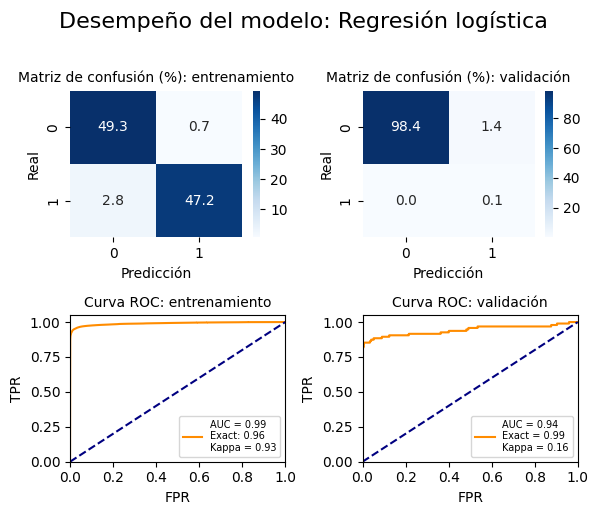

MÉTRICAS DE EVALUACIÓN - ENTRENAMIENTO
F1 Score: 0.96
Precisión: 0.98
Recall: 0.94

Reporte de clasificación:


,precision,recall,f1-score,support
0,0.95,0.99,0.97,226602.00
1,0.98,0.94,0.96,226602.00
accuracy,0.96,0.96,0.96,0.96
macro avg,0.97,0.96,0.96,453204.00
weighted avg,0.97,0.96,0.96,453204.00



MÉTRICAS DE EVALUACIÓN - VALIDACIÓN
F1 Score: 0.17
Precisión: 0.09
Recall: 0.85

Reporte de clasificación:


,precision,recall,f1-score,support
0,1.00,0.99,0.99,56651.00
1,0.09,0.85,0.17,95.00
accuracy,0.99,0.99,0.99,0.99
macro avg,0.55,0.92,0.58,56746.00
weighted avg,1.00,0.99,0.99,56746.00


In [12]:
plot_confusion_and_roc(best_model, X_train=X_train, y_train=y_train, X_test=X_test, y_test=y_test, modelo='Regresión logística', class_labels=None)

Curva roc para el ajuste del modelo de entrenamiento:

Dado que en este caso la señal de que el modelo funciona bien es el **f1-score** sobre la detección del fraude, se utilizara esta métrica para comparar cual modelo es mejor para detectarlo 

In [22]:
# 
# Guarda el modelo entrenado en un DataFrame
modelos=[]
f1_score_fraudes=[]
modelos.append('regresion_logistica+PCA')
f1_score_fraudes.append(np.round(report_df['f1-score']['1'],2))
pd.DataFrame({
    'Modelo': modelos,
    'f1_score_fraudes': f1_score_fraudes
})

                    Modelo  f1_score_fraudes
0  regresion_logistica+PCA              0.17

## <span style = 'color: cyan'>***2.2.***</span> Bosques aleatorios

In [24]:
pipe_rf = Pipeline([
    ('select', SelectKBest(score_func=mutual_info_classif, k=5)),
    ('clf', RandomForestClassifier(random_state=202508))
])

param_dist_rf = {
    'clf__n_estimators': [100, 200],
    'clf__max_depth': [None, 10]
}

random_search_rf = RandomizedSearchCV(
    pipe_rf,
    param_distributions=param_dist_rf,
    n_iter=2,
    scoring='f1',
    cv=3,
    random_state=202508,
    verbose=1,
    n_jobs=-1
)

random_search_rf.fit(X_train, y_train)


Fitting 3 folds for each of 2 candidates, totalling 6 fits


RandomizedSearchCV(cv=3,
                   estimator=Pipeline(steps=[('select',
                                              SelectKBest(k=5,
                                                          score_func=<function mutual_info_classif at 0x16aedb490>)),
                                             ('clf',
                                              RandomForestClassifier(random_state=202508))]),
                   n_iter=2, n_jobs=-1,
                   param_distributions={'clf__max_depth': [None, 10],
                                        'clf__n_estimators': [100, 200]},
                   random_state=202508, scoring='f1', verbose=1)

Ajuste del mejor modelo:

In [25]:
#
#  Mejor modelo
best_model = random_search_rf.best_estimator_
y_pred = best_model.predict(X_test)
y_proba = best_model.predict_proba(X_test)[:, 1]
best_model

Pipeline(steps=[('select',
                 SelectKBest(k=5,
                             score_func=<function mutual_info_classif at 0x16aedb490>)),
                ('clf', RandomForestClassifier(random_state=202508))])

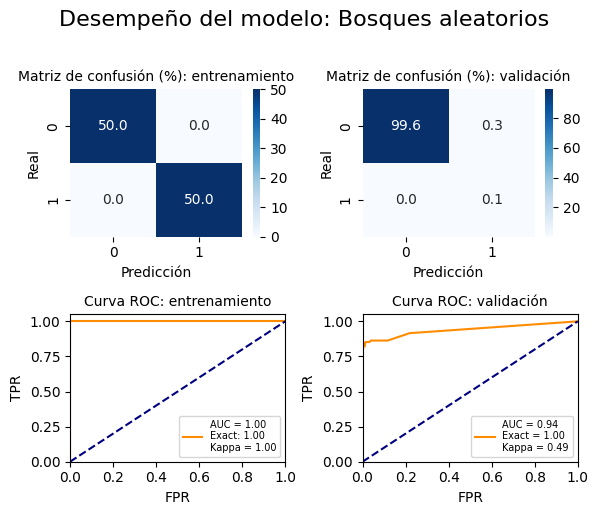

MÉTRICAS DE EVALUACIÓN - ENTRENAMIENTO
F1 Score: 1.00
Precisión: 1.00
Recall: 1.00

Reporte de clasificación:


,precision,recall,f1-score,support
0,1.00,1.00,1.00,226602.00
1,1.00,1.00,1.00,226602.00
accuracy,1.00,1.00,1.00,1.00
macro avg,1.00,1.00,1.00,453204.00
weighted avg,1.00,1.00,1.00,453204.00



MÉTRICAS DE EVALUACIÓN - VALIDACIÓN
F1 Score: 0.49
Precisión: 0.35
Recall: 0.82

Reporte de clasificación:


,precision,recall,f1-score,support
0,1.00,1.00,1.00,56651.00
1,0.35,0.82,0.49,95.00
accuracy,1.00,1.00,1.00,1.00
macro avg,0.68,0.91,0.75,56746.00
weighted avg,1.00,1.00,1.00,56746.00


In [26]:
plot_confusion_and_roc(best_model, X_train=X_train, y_train=y_train, X_test=X_test, y_test=y_test, modelo='Bosques aleatorios', class_labels=None)

Curva roc para el ajuste del modelo de entrenamiento:

Dado que en este caso la señal de que el modelo funciona bien es el **f1-score** sobre la detección del fraude, se utilizara esta métrica para comparar cual modelo es mejor para detectarlo 

In [27]:
# Guarda el modelo entrenado en un DataFrame
modelos.append('regresion_random_forest+PCA')
f1_score_fraudes.append(np.round(report_df['f1-score']['1'],2))
pd.DataFrame({
    'Modelo': modelos,
    'f1_score_fraudes': f1_score_fraudes
})

                        Modelo  f1_score_fraudes
0      regresion_logistica+PCA              0.17
1  regresion_random_forest+PCA              0.17

## <span style = 'color: cyan'>***2.3.***</span> Árboles de decisión

In [29]:

pipe_tree = Pipeline([
    ('select', SelectKBest(score_func=mutual_info_classif, k=5)),
    ('clf', DecisionTreeClassifier(random_state=202508))
])

param_dist_tree = {
    'clf__max_depth': [5, 10],
    'clf__min_samples_split': [2, 5]
}

random_search_tree = RandomizedSearchCV(
    pipe_tree,
    param_distributions=param_dist_tree,
    n_iter=2,
    scoring='f1',
    cv=3,
    random_state=202508,
    verbose=1,
    n_jobs=-1
)

random_search_tree.fit(X_train, y_train)


Fitting 3 folds for each of 2 candidates, totalling 6 fits


RandomizedSearchCV(cv=3,
                   estimator=Pipeline(steps=[('select',
                                              SelectKBest(k=5,
                                                          score_func=<function mutual_info_classif at 0x16aedb490>)),
                                             ('clf',
                                              DecisionTreeClassifier(random_state=202508))]),
                   n_iter=2, n_jobs=-1,
                   param_distributions={'clf__max_depth': [5, 10],
                                        'clf__min_samples_split': [2, 5]},
                   random_state=202508, scoring='f1', verbose=1)

Ajuste del mejor modelo:

In [30]:
# 
# Mejor modelo
best_model = random_search_tree.best_estimator_
y_pred = best_model.predict(X_test)
y_proba = best_model.predict_proba(X_test)[:, 1]
best_model

Pipeline(steps=[('select',
                 SelectKBest(k=5,
                             score_func=<function mutual_info_classif at 0x16aedb490>)),
                ('clf',
                 DecisionTreeClassifier(max_depth=10, min_samples_split=5,
                                        random_state=202508))])

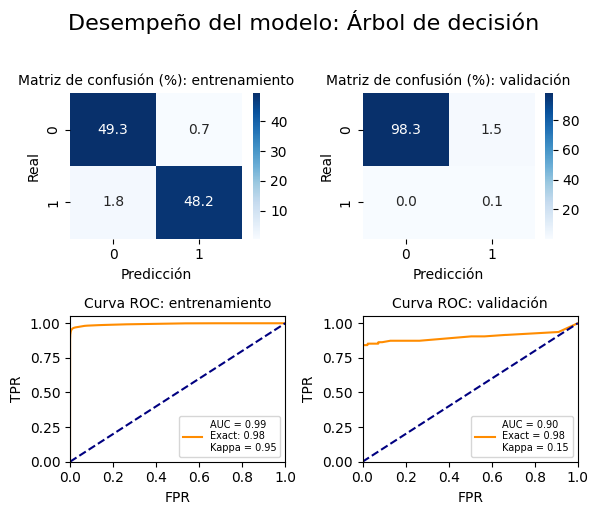

MÉTRICAS DE EVALUACIÓN - ENTRENAMIENTO
F1 Score: 0.98
Precisión: 0.99
Recall: 0.96

Reporte de clasificación:


,precision,recall,f1-score,support
0,0.96,0.99,0.98,226602.00
1,0.99,0.96,0.98,226602.00
accuracy,0.98,0.98,0.98,0.98
macro avg,0.98,0.98,0.98,453204.00
weighted avg,0.98,0.98,0.98,453204.00



MÉTRICAS DE EVALUACIÓN - VALIDACIÓN
F1 Score: 0.15
Precisión: 0.08
Recall: 0.84

Reporte de clasificación:


,precision,recall,f1-score,support
0,1.00,0.98,0.99,56651.00
1,0.08,0.84,0.15,95.00
accuracy,0.98,0.98,0.98,0.98
macro avg,0.54,0.91,0.57,56746.00
weighted avg,1.00,0.98,0.99,56746.00


In [31]:
plot_confusion_and_roc(best_model, X_train=X_train, y_train=y_train, X_test=X_test, y_test=y_test, modelo='Árbol de decisión', class_labels=None)

In [32]:
# Guarda el modelo entrenado en un DataFrame
modelos.append('Decisicion_tree+PCA')
f1_score_fraudes.append(np.round(report_df['f1-score']['1'],2))
pd.DataFrame({
    'Modelo': modelos,
    'f1_score_fraudes': f1_score_fraudes
})

                        Modelo  f1_score_fraudes
0      regresion_logistica+PCA              0.17
1  regresion_random_forest+PCA              0.17
2          Decisicion_tree+PCA              0.17

## <span style = 'color: cyan'>***2.4.***</span> *HGB: Hist gradient boosting*.

Dado que ya se encuentra normalizado el dataset y equilibrado para datos desbalanceados se pasara a correr modelos

In [34]:


pipe_hgb = Pipeline([
    ('select', SelectKBest(score_func=mutual_info_classif, k=5)),
    ('clf', HistGradientBoostingClassifier(random_state=202508))
])

param_dist_hgb = {
    'clf__max_iter': [100, 200],
    'clf__learning_rate': [0.01, 0.1],
    'clf__max_depth': [None, 10],
    'clf__l2_regularization': [0.0, 1.0]
}

random_search_hgb = RandomizedSearchCV(
    pipe_hgb,
    param_distributions=param_dist_hgb,
    n_iter=2,
    scoring='f1',
    cv=3,
    random_state=202508,
    verbose=1,
    n_jobs=-1
)

random_search_hgb.fit(X_train, y_train)


Fitting 3 folds for each of 2 candidates, totalling 6 fits


RandomizedSearchCV(cv=3,
                   estimator=Pipeline(steps=[('select',
                                              SelectKBest(k=5,
                                                          score_func=<function mutual_info_classif at 0x16aedb490>)),
                                             ('clf',
                                              HistGradientBoostingClassifier(random_state=202508))]),
                   n_iter=2, n_jobs=-1,
                   param_distributions={'clf__l2_regularization': [0.0, 1.0],
                                        'clf__learning_rate': [0.01, 0.1],
                                        'clf__max_depth': [None, 10],
                                        'clf__max_iter': [100, 200]},
                   random_state=202508, scoring='f1', verbose=1)

Ajuste del mejor modelo:

In [35]:
# 
# Mejor modelo
best_model = random_search_hgb.best_estimator_
y_pred = best_model.predict(X_test)
y_proba = best_model.predict_proba(X_test)[:, 1]
best_model

Pipeline(steps=[('select',
                 SelectKBest(k=5,
                             score_func=<function mutual_info_classif at 0x16aedb490>)),
                ('clf',
                 HistGradientBoostingClassifier(max_iter=200,
                                                random_state=202508))])

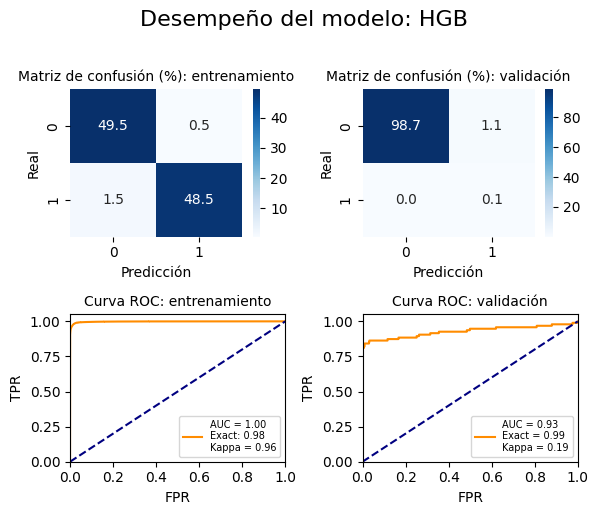

MÉTRICAS DE EVALUACIÓN - ENTRENAMIENTO
F1 Score: 0.98
Precisión: 0.99
Recall: 0.97

Reporte de clasificación:


,precision,recall,f1-score,support
0,0.97,0.99,0.98,226602.00
1,0.99,0.97,0.98,226602.00
accuracy,0.98,0.98,0.98,0.98
macro avg,0.98,0.98,0.98,453204.00
weighted avg,0.98,0.98,0.98,453204.00



MÉTRICAS DE EVALUACIÓN - VALIDACIÓN
F1 Score: 0.20
Precisión: 0.11
Recall: 0.84

Reporte de clasificación:


,precision,recall,f1-score,support
0,1.00,0.99,0.99,56651.00
1,0.11,0.84,0.20,95.00
accuracy,0.99,0.99,0.99,0.99
macro avg,0.56,0.92,0.59,56746.00
weighted avg,1.00,0.99,0.99,56746.00


In [36]:
plot_confusion_and_roc(best_model, X_train=X_train, y_train=y_train, X_test=X_test, y_test=y_test, modelo='HGB', class_labels=None)

In [37]:
# Guarda el modelo entrenado en un DataFrame
modelos.append('hist_gradient_boosting+PCA')
f1_score_fraudes.append(np.round(report_df['f1-score']['1'],2))
pd.DataFrame({
    'Modelo': modelos,
    'f1_score_fraudes': f1_score_fraudes
})

                        Modelo  f1_score_fraudes
0      regresion_logistica+PCA              0.17
1  regresion_random_forest+PCA              0.17
2          Decisicion_tree+PCA              0.17
3   hist_gradient_boosting+PCA              0.17

## <span style = 'color: cyan'>***2.5.***</span> *Redes neuronales: MLP*

In [ ]:
pipe_mlp = Pipeline([
    ('select', SelectKBest(score_func=mutual_info_classif, k=5)),
    ('clf', MLPClassifier(max_iter=200, random_state=202508))
])

param_dist_mlp = {
    'clf__hidden_layer_sizes': [(50,), (100,)],
    'clf__activation': ['relu'],
    'clf__alpha': [0.0001, 0.001]
}

random_search_mlp = RandomizedSearchCV(
    pipe_mlp,
    param_distributions=param_dist_mlp,
    n_iter=2,
    scoring='f1',
    cv=3,
    random_state=202508,
    verbose=1,
    n_jobs=-1
)

random_search_mlp.fit(X_train, y_train)


Fitting 3 folds for each of 2 candidates, totalling 6 fits


/Users/scuartasr/Documents/Maestría/aprenmaq/aprendmaq_proy_final/.venv/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/scuartasr/Documents/Maestría/aprenmaq/aprendmaq_proy_final/.venv/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/scuartasr/Documents/Maestría/aprenmaq/aprendmaq_proy_final/.venv/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/scuartasr/Documents/Maestría/aprenmaq/aprendmaq_proy_final/.venv/lib/python3.10/site-packages/sklearn/neural_network/_m

RandomizedSearchCV(cv=3,
                   estimator=Pipeline(steps=[('select',
                                              SelectKBest(k=5,
                                                          score_func=<function mutual_info_classif at 0x16aedb490>)),
                                             ('clf',
                                              MLPClassifier(random_state=202508))]),
                   n_iter=2, n_jobs=-1,
                   param_distributions={'clf__activation': ['relu'],
                                        'clf__alpha': [0.0001, 0.001],
                                        'clf__hidden_layer_sizes': [(50,),
                                                                    (100,)]},
                   random_state=202508, scoring='f1', verbose=1)

Ajuste del mejor modelo:

In [39]:
# 
# Mejor modelo
best_model = random_search_mlp.best_estimator_
y_pred = best_model.predict(X_test)
y_proba = best_model.predict_proba(X_test)[:, 1]
best_model

Pipeline(steps=[('select',
                 SelectKBest(k=5,
                             score_func=<function mutual_info_classif at 0x16aedb490>)),
                ('clf', MLPClassifier(alpha=0.001, random_state=202508))])

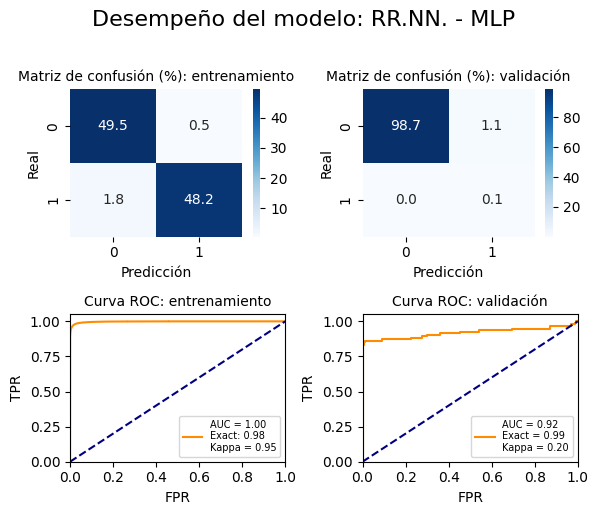

MÉTRICAS DE EVALUACIÓN - ENTRENAMIENTO
F1 Score: 0.98
Precisión: 0.99
Recall: 0.96

Reporte de clasificación:


,precision,recall,f1-score,support
0,0.97,0.99,0.98,226602.00
1,0.99,0.96,0.98,226602.00
accuracy,0.98,0.98,0.98,0.98
macro avg,0.98,0.98,0.98,453204.00
weighted avg,0.98,0.98,0.98,453204.00



MÉTRICAS DE EVALUACIÓN - VALIDACIÓN
F1 Score: 0.20
Precisión: 0.12
Recall: 0.85

Reporte de clasificación:


,precision,recall,f1-score,support
0,1.00,0.99,0.99,56651.00
1,0.12,0.85,0.20,95.00
accuracy,0.99,0.99,0.99,0.99
macro avg,0.56,0.92,0.60,56746.00
weighted avg,1.00,0.99,0.99,56746.00


In [40]:
plot_confusion_and_roc(best_model, X_train=X_train, y_train=y_train, X_test=X_test, y_test=y_test, modelo='RR.NN. - MLP', class_labels=None)

In [42]:
# Guarda el modelo entrenado en un DataFrame
modelos.append('MLP_classifier+PCA')
f1_score_fraudes.append(np.round(report_df['f1-score']['1'],2))
pd.DataFrame({
    'Modelo': modelos,
    'f1_score_fraudes': f1_score_fraudes
})

                        Modelo  f1_score_fraudes
0      regresion_logistica+PCA              0.17
1  regresion_random_forest+PCA              0.17
2          Decisicion_tree+PCA              0.17
3   hist_gradient_boosting+PCA              0.17
4           MLP_classifier+PCA              0.20

## <span style = 'color: cyan'>***2.6.***</span> *LGBM. Light gradient boosting*

In [44]:


pipe_lgbm = Pipeline([
    ('select', SelectKBest(score_func=mutual_info_classif, k=5)),
    ('clf', LGBMClassifier(random_state=202508))
])

param_dist_lgbm = {
    'clf__n_estimators': [100, 200],
    'clf__max_depth': [5, 10, -1],
    'clf__learning_rate': [0.01, 0.1]
}

random_search_lgbm = RandomizedSearchCV(
    pipe_lgbm,
    param_distributions=param_dist_lgbm,
    n_iter=2,
    scoring='f1',
    cv=3,
    random_state=202508,
    verbose=1,
    n_jobs=-1
)

random_search_lgbm.fit(X_train, y_train)


Fitting 3 folds for each of 2 candidates, totalling 6 fits
[LightGBM] [Info] Number of positive: 151068, number of negative: 151068
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000866 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1275
[LightGBM] [Info] Number of data points in the train set: 302136, number of used features: 5
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Number of positive: 151068, number of negative: 151068
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002070 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1275
[LightGBM] [Info] Number of 

RandomizedSearchCV(cv=3,
                   estimator=Pipeline(steps=[('select',
                                              SelectKBest(k=5,
                                                          score_func=<function mutual_info_classif at 0x16aedb490>)),
                                             ('clf',
                                              LGBMClassifier(random_state=202508))]),
                   n_iter=2, n_jobs=-1,
                   param_distributions={'clf__learning_rate': [0.01, 0.1],
                                        'clf__max_depth': [5, 10, -1],
                                        'clf__n_estimators': [100, 200]},
                   random_state=202508, scoring='f1', verbose=1)

Ajuste del mejor modelo:

In [45]:
# Mejor modelo
best_model = random_search_lgbm.best_estimator_
y_pred = best_model.predict(X_test)
y_proba = best_model.predict_proba(X_test)[:, 1]
best_model

Pipeline(steps=[('select',
                 SelectKBest(k=5,
                             score_func=<function mutual_info_classif at 0x16aedb490>)),
                ('clf', LGBMClassifier(max_depth=5, random_state=202508))])

Curva roc para el ajuste del modelo de entrenamiento:

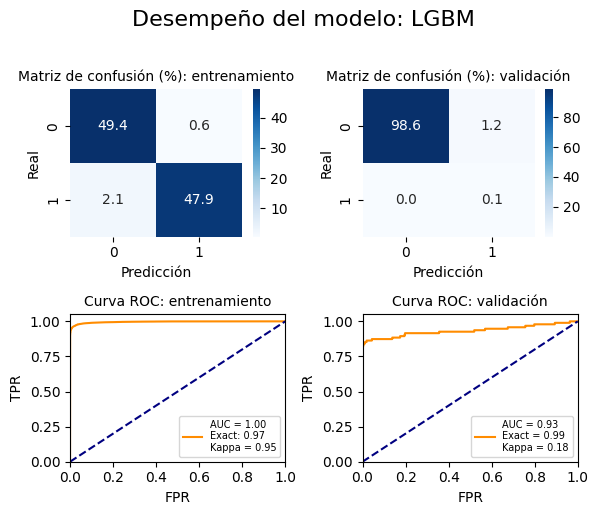

MÉTRICAS DE EVALUACIÓN - ENTRENAMIENTO
F1 Score: 0.97
Precisión: 0.99
Recall: 0.96

Reporte de clasificación:


,precision,recall,f1-score,support
0,0.96,0.99,0.97,226602.00
1,0.99,0.96,0.97,226602.00
accuracy,0.97,0.97,0.97,0.97
macro avg,0.97,0.97,0.97,453204.00
weighted avg,0.97,0.97,0.97,453204.00



MÉTRICAS DE EVALUACIÓN - VALIDACIÓN
F1 Score: 0.19
Precisión: 0.10
Recall: 0.85

Reporte de clasificación:


,precision,recall,f1-score,support
0,1.00,0.99,0.99,56651.00
1,0.10,0.85,0.19,95.00
accuracy,0.99,0.99,0.99,0.99
macro avg,0.55,0.92,0.59,56746.00
weighted avg,1.00,0.99,0.99,56746.00


In [46]:
plot_confusion_and_roc(best_model, X_train=X_train, y_train=y_train, X_test=X_test, y_test=y_test, modelo='LGBM', class_labels=None)

Dado que en este caso la señal de que el modelo funciona bien es el **f1-score** sobre la detección del fraude, se utilizara esta métrica para comparar cual modelo es mejor para detectarlo 

In [47]:
# Guarda el modelo entrenado en un DataFrame
modelos.append('lgbm_classifier+PCA')
f1_score_fraudes.append(np.round(report_df['f1-score']['1'],2))
pd.DataFrame({
    'Modelo': modelos,
    'f1_score_fraudes': f1_score_fraudes
})

                        Modelo  f1_score_fraudes
0      regresion_logistica+PCA              0.17
1  regresion_random_forest+PCA              0.17
2          Decisicion_tree+PCA              0.17
3   hist_gradient_boosting+PCA              0.17
4           MLP_classifier+PCA              0.20
5          lgbm_classifier+PCA              0.20

## <span style = 'color: cyan'>***2.6.***</span> *XGBM. Extreme gradient boosting*

### <span style = 'color: green'>**3.1.7**</span> Modelación basado ajuste PCA-Equilibrio-XGBOOST:

Dado que ya se encuentra normalizado el dataset y equilibrado para datos desbalanceados se pasara a correr modelos

In [49]:


pipe_xgb = Pipeline([
    ('select', SelectKBest(score_func=mutual_info_classif, k=5)),
    ('clf', XGBClassifier(random_state=202508, use_label_encoder=False, eval_metric='logloss'))
])

param_dist_xgb = {
    'clf__n_estimators': [100, 200],
    'clf__max_depth': [5, 10],
    'clf__learning_rate': [0.01, 0.1]
}

random_search_xgb = RandomizedSearchCV(
    pipe_xgb,
    param_distributions=param_dist_xgb,
    n_iter=2,
    scoring='f1',
    cv=3,
    random_state=202508,
    verbose=1,
    n_jobs=-1
)

random_search_xgb.fit(X_train, y_train)


Fitting 3 folds for each of 2 candidates, totalling 6 fits


/Users/scuartasr/Documents/Maestría/aprenmaq/aprendmaq_proy_final/.venv/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [19:33:25] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Users/scuartasr/Documents/Maestría/aprenmaq/aprendmaq_proy_final/.venv/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [19:33:25] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Users/scuartasr/Documents/Maestría/aprenmaq/aprendmaq_proy_final/.venv/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [19:33:25] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Users/scuartasr/Documents/Maestría/aprenmaq/aprendmaq_proy_final/

RandomizedSearchCV(cv=3,
                   estimator=Pipeline(steps=[('select',
                                              SelectKBest(k=5,
                                                          score_func=<function mutual_info_classif at 0x16aedb490>)),
                                             ('clf',
                                              XGBClassifier(base_score=None,
                                                            booster=None,
                                                            callbacks=None,
                                                            colsample_bylevel=None,
                                                            colsample_bynode=None,
                                                            colsample_bytree=None,
                                                            device=None,
                                                            early_stopping_rounds=None,
                                                            enable_categorical=False,
                                                            eval_metric='logloss',...
                                                            max_delta_step=None,
                                                            max_depth=None,
                                                            max_leaves=None,
                                                            min_child_weight=None,
                                                            missing=nan,
                                                            monotone_constraints=None,
                                                            multi_strategy=None,
                                                            n_estimators=None,
                                                            n_jobs=None,
                                                            num_parallel_tree=None, ...))]),
                   n_iter=2, n_jobs=-1,
                   param_distributions={'clf__learning_rate': [0.01, 0.1],
                                        'clf__max_depth': [5, 10],
                                        'clf__n_estimators': [100, 200]},
                   random_state=202508, scoring='f1', verbose=1)

In [50]:
# Mejor modelo
best_model = random_search_xgb.best_estimator_
y_pred = best_model.predict(X_test)
y_proba = best_model.predict_proba(X_test)[:, 1]
best_model

Pipeline(steps=[('select',
                 SelectKBest(k=5,
                             score_func=<function mutual_info_classif at 0x16aedb490>)),
                ('clf',
                 XGBClassifier(base_score=None, booster=None, callbacks=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=None, device=None,
                               early_stopping_rounds=None,
                               enable_categorical=False, eval_metric='logloss',
                               feature_types=None, feature_weights=None,
                               gamma=None, grow_policy=None,
                               importance_type=None,
                               interaction_constraints=None, learning_rate=0.1,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=5, max_leaves=None,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, multi_strategy=None,
                               n_estimators=100, n_jobs=None,
                               num_parallel_tree=None, ...))])

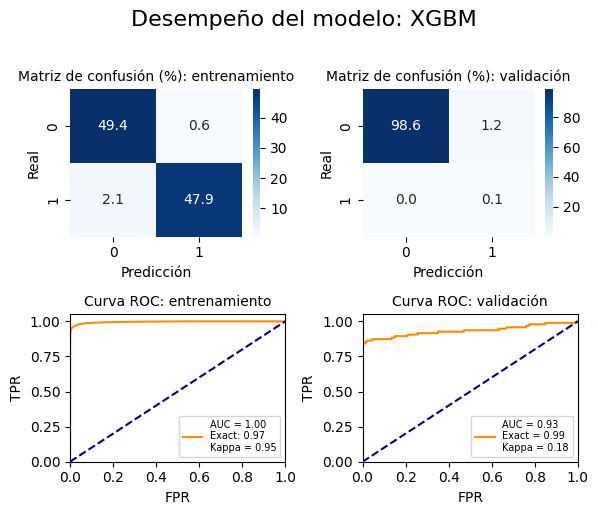

MÉTRICAS DE EVALUACIÓN - ENTRENAMIENTO
F1 Score: 0.97
Precisión: 0.99
Recall: 0.96

Reporte de clasificación:


,precision,recall,f1-score,support
0,0.96,0.99,0.97,226602.00
1,0.99,0.96,0.97,226602.00
accuracy,0.97,0.97,0.97,0.97
macro avg,0.97,0.97,0.97,453204.00
weighted avg,0.97,0.97,0.97,453204.00



MÉTRICAS DE EVALUACIÓN - VALIDACIÓN
F1 Score: 0.18
Precisión: 0.10
Recall: 0.84

Reporte de clasificación:


,precision,recall,f1-score,support
0,1.00,0.99,0.99,56651.00
1,0.10,0.84,0.18,95.00
accuracy,0.99,0.99,0.99,0.99
macro avg,0.55,0.91,0.59,56746.00
weighted avg,1.00,0.99,0.99,56746.00


In [52]:
plot_confusion_and_roc(best_model, X_train=X_train, y_train=y_train, X_test=X_test, y_test=y_test, modelo='XGBM', class_labels=None)

In [53]:
# Guarda el modelo entrenado en un DataFrame
modelos.append('XGBM+PCA')
f1_score_fraudes.append(np.round(report_df['f1-score']['1'],2))
pd.DataFrame({
    'Modelo': modelos,
    'f1_score_fraudes': f1_score_fraudes
}).sort_values('f1_score_fraudes', ascending=False).reset_index(drop=True)

                        Modelo  f1_score_fraudes
0           MLP_classifier+PCA              0.20
1          lgbm_classifier+PCA              0.20
2                     XGBM+PCA              0.20
3      regresion_logistica+PCA              0.17
4  regresion_random_forest+PCA              0.17
5          Decisicion_tree+PCA              0.17
6   hist_gradient_boosting+PCA              0.17

Finalmente basado en los datos obtenidos concluimos que el mejor modelo basado en la información persistente y bajo las transformaciones obtenidas es randomforest con PCA